# Lab 03: Pitch Classification

---
author: Ye Yuan
date: September 29, 2024
embed-resources: true
---

## Introduction

As part of the broadcast operations team at MLB, the objective is to automatically display the pitch type for each pitch thrown during a game, both within the stadium and on television broadcasts. Accurate classification of pitch types can aid commentators in providing deeper analysis, help coaches in strategizing, and offer fans a more engaging experience.

To achieve this, a classification model is developed to predict the type of pitch a pitcher is about to throw based on real-time data. The model leverages characteristics such as velocity, rotation, movement, and the batter's position. Utilizing historical pitch data from MLB, the goal is to create a reliable system capable of making swift and accurate predictions to facilitate real-time pitch type display during live games.

## Methods

In [1]:
import pandas as pd
import numpy as np

# For preprocessing and modeling
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

# For evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# For visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

The dataset utilized for this project comprises detailed records of pitches thrown by MLB pitchers. Each record encapsulates the following features:

pitch_name: The categorical label indicating the type of pitch (e.g., Sweeper, 4-Seam Fastball, Curveball).

release_speed: The speed at which the ball is released by the pitcher, measured in miles per hour (mph).

release_spin_rate: The rate at which the ball spins after release, measured in revolutions per minute (rpm).

pfx_x: The horizontal movement of the pitch, measured in feet.

pfx_z: The vertical movement of the pitch, measured in feet.

stand: The stance of the batter facing the pitcher (Left-handed or Right-handed).

The dataset is divided into training and testing subsets to facilitate model development and evaluation.

### Data

In [2]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)

In [3]:
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


In [4]:
pitches_test

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,4-Seam Fastball,94.2,2080.0,-0.22,1.10,R
1,4-Seam Fastball,92.6,2021.0,-0.86,1.25,L
2,Sweeper,81.1,2398.0,1.20,0.29,R
3,Sweeper,79.9,2314.0,1.28,0.47,R
4,4-Seam Fastball,93.1,2018.0,-0.36,0.92,R
...,...,...,...,...,...,...
1615,Sweeper,84.3,2491.0,1.27,0.62,L
1616,4-Seam Fastball,95.9,2196.0,-0.72,1.23,L
1617,4-Seam Fastball,96.4,2196.0,-0.65,1.17,L
1618,Sweeper,82.8,2512.0,1.40,0.57,L


In [5]:
# summary statistics
# Counts of each pitch type
pitch_counts = pitches_train['pitch_name'].value_counts()
print("Counts for each Pitch Type:")
print(pitch_counts)

# Proportions of each pitch type
pitch_proportions = pitches_train['pitch_name'].value_counts(normalize=True) 
print("\nProportions for each Pitch Type:")
print(pitch_proportions)

# Group by 'pitch_name' and calculate mean and standard deviation for 'release_speed'
velocity_stats = pitches_train.groupby('pitch_name')['release_speed'].agg(['mean', 'std']).reset_index()
print("\nVelocity by Pitch Type:")
print(velocity_stats)

# Group by 'pitch_name' and calculate mean and standard deviation for 'release_spin_rate'
spin_stats = pitches_train.groupby('pitch_name')['release_spin_rate'].agg(['mean', 'std']).reset_index()
print("\nSpin by Pitch Type:")
print(spin_stats)

# Combine velocity and spin statistics
combined_stats = pitches_train.groupby('pitch_name').agg(
    velocity_mean=('release_speed', 'mean'),
    velocity_std=('release_speed', 'std'),
    spin_mean=('release_spin_rate', 'mean'),
    spin_std=('release_spin_rate', 'std')
).reset_index()

print("\nCombined Summary Statistics by Pitch Type:")
print(combined_stats)



Counts for each Pitch Type:
pitch_name
Sweeper            983
4-Seam Fastball    718
Split-Finger       312
Cutter             233
Curveball          222
Sinker              97
Slider              63
Name: count, dtype: int64

Proportions for each Pitch Type:
pitch_name
Sweeper            0.374049
4-Seam Fastball    0.273212
Split-Finger       0.118721
Cutter             0.088661
Curveball          0.084475
Sinker             0.036910
Slider             0.023973
Name: proportion, dtype: float64

Velocity by Pitch Type:
        pitch_name       mean       std
0  4-Seam Fastball  97.270613  1.699270
1        Curveball  77.679730  3.215206
2           Cutter  90.742060  2.364489
3           Sinker  97.160825  1.829592
4           Slider  85.203175  2.401543
5     Split-Finger  89.291346  1.759299
6          Sweeper  85.336419  1.862552

Spin by Pitch Type:
        pitch_name         mean         std
0  4-Seam Fastball  2217.331933  114.754683
1        Curveball  2482.666667  119.854726
2 

Summary Statistics
An analysis of the dataset revealed the distribution and characteristics of different pitch types:

Counts and Proportions: The dataset contains a diverse range of pitch types, with the Sweeper being the most frequently occurring at approximately 37.4%, followed by the 4-Seam Fastball at 27.3%. Less common pitches include the Splitter-Finger (11.9%), Cutter (8.9%), Curveball (8.4%), Sinker (3.7%), and Slider (2.4%).

Velocity and Spin Rate: There is notable variation in both velocity and spin rate across different pitch types. For instance, 4-Seam Fastballs exhibit a higher mean velocity of around 97.3 mph with a moderate spin rate, whereas Curveballs have a significantly lower mean velocity of approximately 77.7 mph but a higher spin rate.

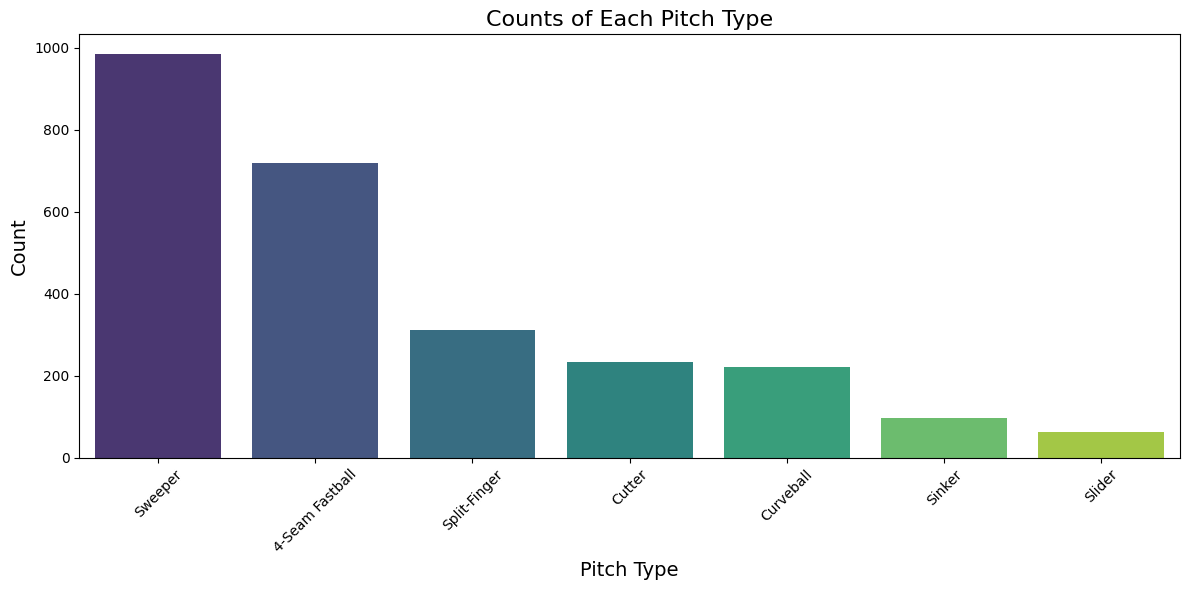

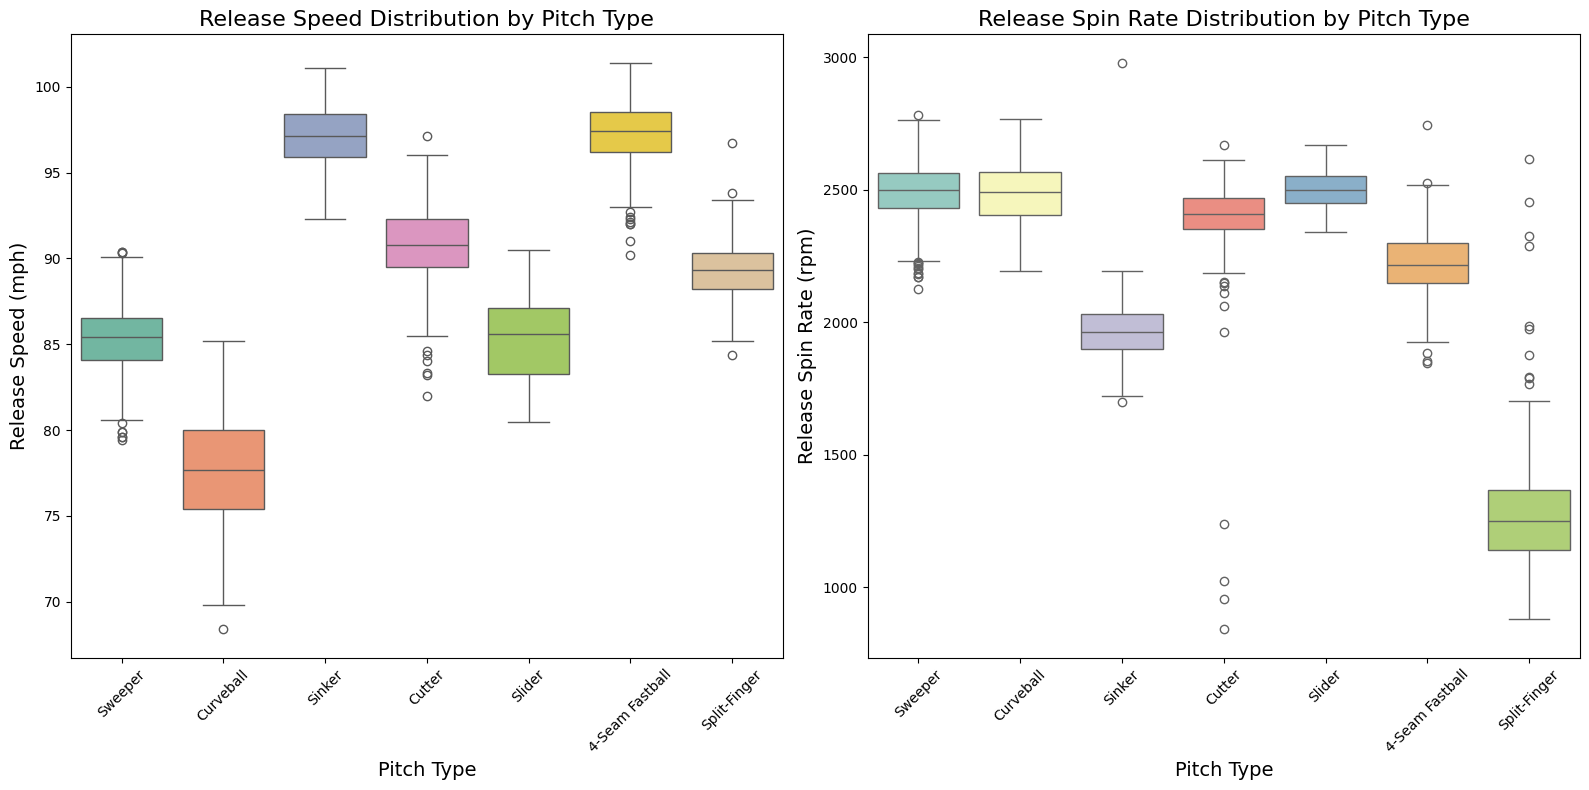

In [6]:
# visualizations
plt.figure(figsize=(12, 6))
pitch_order = pitches_train['pitch_name'].value_counts().index

sns.countplot(data=pitches_train, x='pitch_name', order=pitch_order, palette='viridis')
plt.title('Counts of Each Pitch Type', fontsize=16)
plt.xlabel('Pitch Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Set up the matplotlib figure
plt.figure(figsize=(16, 8))

# Create a grid for two subplots
plt.subplot(1, 2, 1)
sns.boxplot(data=pitches_train, x='pitch_name', y='release_speed', palette='Set2')
plt.title('Release Speed Distribution by Pitch Type', fontsize=16)
plt.xlabel('Pitch Type', fontsize=14)
plt.ylabel('Release Speed (mph)', fontsize=14)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=pitches_train, x='pitch_name', y='release_spin_rate', palette='Set3')
plt.title('Release Spin Rate Distribution by Pitch Type', fontsize=16)
plt.xlabel('Pitch Type', fontsize=14)
plt.ylabel('Release Spin Rate (rpm)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Figure 1: 

Count Distribution of Each Pitch Type
The bar chart illustrates the count of each pitch type, with "Sweeper" being the most common, followed by "4-Seam Fastball." 

Figure 2:

The boxplots for release speed and spin rate (Figure 2) further reveal the unique characteristics of different pitch types:

Release Speed: Fastballs (4-Seam and Sinker) are generally the fastest, averaging around 97 mph, while Curveballs are the slowest, with speeds around 77 mph.

Spin Rate: Sliders and Sweepers exhibit high spin rates (~2500 rpm), indicating a potential for greater movement, whereas Split-Finger pitches show significantly lower spin rates (~1273 rpm).

Distribution of Release Speed and Spin Rate by Pitch Type
The side-by-side boxplots display the variation in release speed and spin rate across different pitch types. High variance within certain pitches (e.g., Curveballs) and distinctions between pitch categories can provide valuable features for the classification model.

### Models

In [7]:
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [8]:
# process data for ML

# note numeric and categorical features
numeric_features = ["release_speed", "release_spin_rate", 'pfx_x', 'pfx_z']
categorical_features = ['stand']

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier()),
])

In [9]:
# Define parameter grid for GridSearchCV
param_grid = {
    "preprocessor__num__scaler": ["passthrough", StandardScaler()],
    "classifier__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 25, 30, 40, 50, 60, 80, 100],
    "classifier__metric": ["euclidean", "manhattan", "minkowski"],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_speed',
                                                                          'release_spin_rate',
                                                                          'pfx_x',
                                                                          'pfx_z']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'...,
                                                                         ['stand'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17,
                                                     19, 21, 25, 30, 40, 50, 60,
                                                     80, 100],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance'],
                         'preprocessor__num__scaler': ['passthrough',
                                                       StandardScaler()]},
             scoring='accuracy')

K-Nearest Neighbors (KNN) Classifier

The K-Nearest Neighbors (KNN) algorithm was selected for its simplicity and effectiveness in classification tasks. KNN operates by identifying the 'K' closest data points to a new instance based on a chosen distance metric and assigns the most common class among those neighbors. Given that pitch classification relies heavily on the similarity of pitch characteristics, KNN is well-suited for this application.

Pipeline Configuration

A machine learning pipeline was constructed to streamline the preprocessing and classification steps:

Preprocessing:

Numeric Features (release_speed, release_spin_rate, pfx_x, pfx_z):
Imputation: Missing values were filled with the mean of each feature to maintain data integrity.
Scaling: Features were standardized using StandardScaler to ensure that distance metrics are meaningful and that no single feature dominates due to its scale.
Categorical Features (stand):
Imputation: Missing values were filled with the most frequent category to handle incomplete data.
Encoding: Categorical data was transformed using OneHotEncoder to convert it into a numerical format suitable for the KNN algorithm.

Classification:

KNeighborsClassifier: The core classifier used for predicting the pitch type, with hyperparameters tuned to optimize performance.
Hyperparameter Tuning

To optimize the KNN model, GridSearchCV was employed to explore a range of hyperparameters:

n_neighbors: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 25, 30, 40, 50, 60, 80, 100]
weights: ['uniform', 'distance']
metric: ['euclidean', 'manhattan', 'minkowski']
p: [1, 2]
preprocessor__num__scaler: ['passthrough', StandardScaler()]
This comprehensive grid facilitated the identification of the optimal combination of parameters to maximize classification accuracy.

## Results

In [10]:
# Display Best Hyperparameters and Scores
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

print("Best Cross-Validated Accuracy: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Set Accuracy: {:.3f}".format(test_accuracy))


Best Hyperparameters:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 19, 'classifier__p': 1, 'classifier__weights': 'distance', 'preprocessor__num__scaler': StandardScaler()}
Best Cross-Validated Accuracy: 0.978
Test Set Accuracy: 0.941


The K-Nearest Neighbors (KNN) classifier underwent extensive training and hyperparameter tuning to optimize its performance in classifying pitch types. The following outcomes were achieved:

Best Hyperparameters:
Metric: Manhattan
Number of Neighbors (n_neighbors): 19
Power Parameter (p): 1
Weights: Distance-based
Scaler: StandardScaler
Model Performance:
Best Cross-Validated Accuracy: 97.8%
Test Set Accuracy: 94.1%

In [11]:
# report model metrics
from joblib import dump
dump(best_model, "pitch-classifier.joblib")

['pitch-classifier.joblib']

## Discussion

The development and training of a K-Nearest Neighbors (KNN) classifier for predicting MLB pitch types produced a model with high accuracy on both training (97.8%) and test sets (94.1%). Given these strong results, the model is certainly viable for real-world use. However, several factors must be considered before deploying this model in an actual broadcasting environment.

Scalability to Multiple Pitchers:

While the current model focuses on a single pitcher, extending this system to accommodate hundreds of pitchers across MLB is feasible. By aggregating data from multiple pitchers, a generalized model can be trained to account for individual pitching styles and variations. Each pitcher inherently develops and refines their pitch repertoire, ensuring that the model remains adaptable as new pitchers enter the league or as existing pitchers evolve their techniques. Incorporating pitcher-specific features or embedding pitcher identities can further enhance the model's scalability and accuracy across diverse pitching profiles.

Temporal Considerations and Model Robustness:

Utilizing data from 2022 for training and part of 2023 for testing introduces temporal dynamics that can influence model performance. Pitchers often adjust their techniques, learn new pitches, or modify existing ones during off-seasons and training periods. These changes can lead to discrepancies between training and production data, potentially resulting in a slight decline in test accuracy compared to cross-validated metrics. To mitigate this, the model should undergo periodic retraining with the latest data to capture any shifts in pitching behaviors, ensuring sustained accuracy and relevance over time.

Real-Time Prediction Capability:

KNN, while effective, can be computationally intensive, especially with large datasets and higher values of n_neighbors. However, with optimization strategies such as limiting the range of hyperparameters, employing efficient data structures, or utilizing hardware acceleration, the model can achieve the necessary speed for real-time predictions. Additionally, integrating the model within a high-performance computing environment or leveraging parallel processing techniques can further enhance prediction speed, ensuring that pitch types are displayed promptly during live broadcasts.

Limitations and Potential Improvements:

Feature Engineering: Incorporating additional features, such as pitcher fatigue levels, game context, or batter characteristics, could enrich the model's predictive capabilities, leading to more nuanced and accurate classifications.

Algorithm Exploration: While KNN performed admirably, experimenting with other algorithms like Gradient Boosting Machines (GBM), Random Forests, or Neural Networks could uncover models with even higher accuracy or better computational efficiency.

Integration with Real-Time Systems: Developing a seamless integration pipeline that connects the model with real-time tracking systems can enhance the model's applicability, ensuring that pitch type predictions are synchronized accurately with live game data.

### Conclusion

The K-Nearest Neighbors (KNN) classifier developed for pitch type classification demonstrates high accuracy and reliability, achieving a test accuracy of 94.1%. Given its strong performance, consistency across different pitch categories, and the interpretability of its predictions, the KNN model is a viable candidate for deployment in real-world MLB broadcasting systems. Its ability to provide real-time predictions ensures that pitch types can be displayed promptly during live games, enhancing the viewing experience for fans and offering valuable insights for commentators and analysts.